<a href="https://colab.research.google.com/github/loroldoesmath/intro-to-ML/blob/main/kNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# k-Nearest Neighbors

In this notebook, we'll explore k-Nearest Neighbors, a supervised learning classification technique that predicts the label of a data point by looking at the k closest neighbors and their labels.

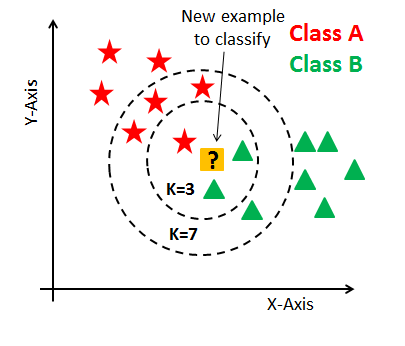

✍🏼 In order to edit this notebook, make a copy and save it in your Google Drive.


# Necessary Libraries

We're going to start by importing the necessary libraries:



*   **pandas** - to load the dataset into a DataFrame and help us encode our categorical variables
*   **numpy** - supports numerical operations
*   **sklearn.model_selection** - we use train_test_split to divide the dataset into our training and testing subsets
*   **sklearn.preprocessing** - we're going to use LabelEncoder to encode categorical columns
*   **sklearn.neighbors** - to implement out kNN algorithm, we'll use KNeighborsClassifier
*   **sklearn.metrics** - helps us evaluate our model's performance
*   **matplotlib.pyplot** - helps us visualize our data
*   **seaborn** - makes our visualizations prettier
*   **IPython.display** - .display() allows us to neatly display our datasets and outputs












In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Dataset

For this assignment, we'll be using this [Heart Health Dataset](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset).

Let's import it and take a look at the variables we're working with.



In [ ]:
# Select a locally downloaded file - brain_stroke.csv
from google.colab import files
uploaded = files.upload()

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Upload dataset
df = pd.read_csv('heart.csv')

# See first five rows + meta data
display(df.head())
df.info()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


<ipython-input-17-71356050cbd6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='output', data=df, palette='viridis')


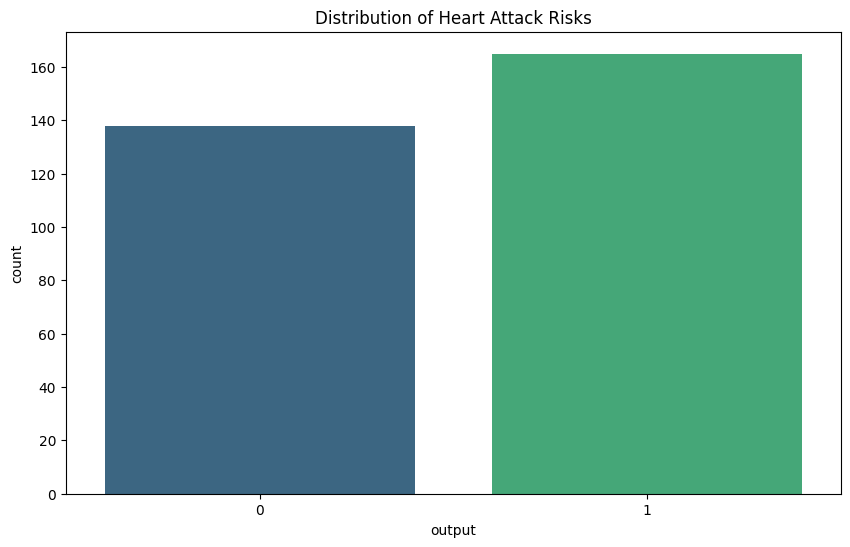

In [ ]:
# Visualize dataset distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='output', data=df, palette='viridis')
plt.title('Distribution of Heart Attack Risks')
plt.show()

❓Does this dataset's target variable look fairly balanced?

# Data Preprocessing

We need to seperate the features (the data that helps us make classifications) and our target (what we're trying to predict).

Next, we split our data into training and test sets. In this case, test_size = 0.3 allocates 30% of the data to the test set and 70% to the training set. The random_state parameter in the train_test_split function ensures that the seed value for the random number generator that helps the function randomly split data is the same. Using the same seed value helps ensure *reproducibility*; machine learning engineers often need to reproduce results to debug, share with colleagues, and compare different models. The number 42 is a reference to the science fiction series "The Hitchhiker's Guide to the Galaxy", and has become embraced by the programming and data science community. However, you can use any seed value you like (as long as you can remember what you used).

Finally, we're going to standardize the numerical features. Revisit our Preprocessing notebook for an overview of standardization.




In [ ]:
# Separate features and target
X = df.drop('output', axis=1)
y = df['output']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


👀 Let's visualize the changes made via Standardization:

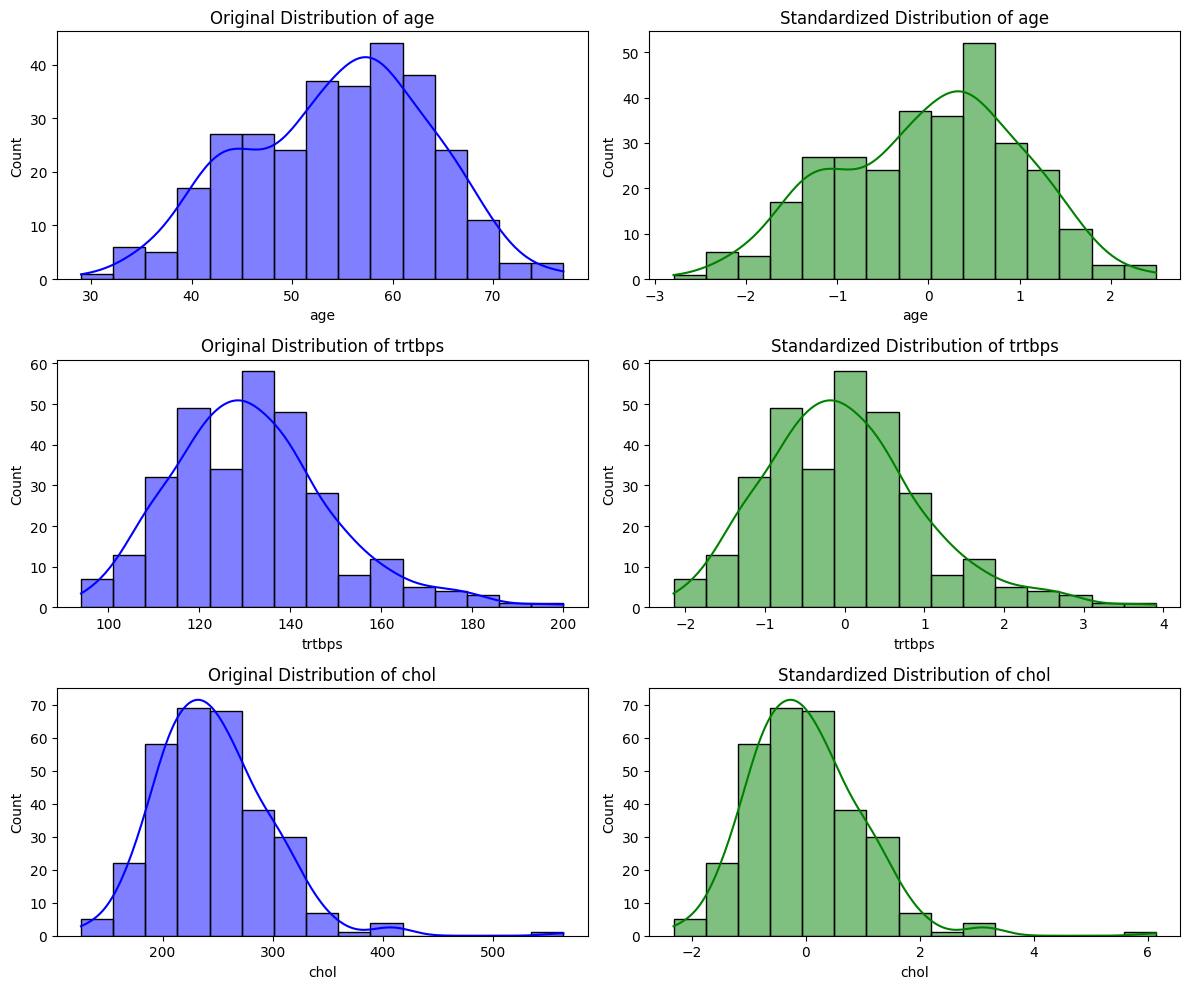

In [ ]:
# Identify continuous features
continuous_features = ['age', 'trtbps', 'chol']

# Fit the scaler on continuous features of the training data
scaler = StandardScaler()
scaler.fit(df[continuous_features])

# Standardize continuous features for visualization
standardized_data = pd.DataFrame(
    scaler.transform(df[continuous_features]),
    columns=continuous_features
)

# Plot histograms for each feature before and after standardization
fig, axes = plt.subplots(len(continuous_features), 2, figsize=(12, 10))

for i, feature in enumerate(continuous_features):
    # Original feature distribution
    sns.histplot(df[feature], ax=axes[i, 0], kde=True, color='blue', bins=15)
    axes[i, 0].set_title(f'Original Distribution of {feature}')
    axes[i, 0].set_xlabel(feature)

    # Standardized feature distribution
    sns.histplot(standardized_data[feature], ax=axes[i, 1], kde=True, color='green', bins=15)
    axes[i, 1].set_title(f'Standardized Distribution of {feature}')
    axes[i, 1].set_xlabel(feature)

plt.tight_layout()
plt.show()


Now, we're going to implement the k-Nearest Neighbors model:



```
knn = KNeighborsClassifier(n_neighbors=k) # Classifier implementing the k-nearest neighbors vote.
knn.fit(X_train, y_train) # Fit the model to our training data
y_pred = knn.predict(X_test) # Make predictions
```

✅ Try it yourself: Implement the model with the number of neighbors equal to = 3. You might find it useful to write a function that runs your kNN model, so you can see the difference with more values of k later.

Accuracy for k=3: 0.84

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.85      0.82        41
           1       0.87      0.82      0.85        50

    accuracy                           0.84        91
   macro avg       0.83      0.84      0.83        91
weighted avg       0.84      0.84      0.84        91



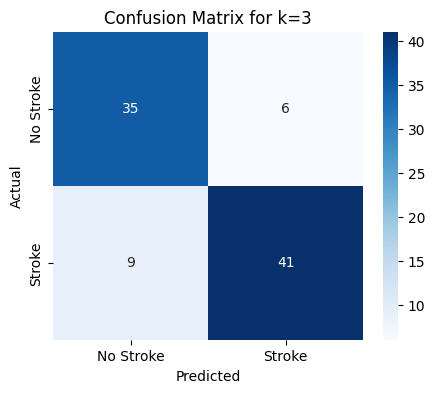

In [ ]:
# Note that students don't have to create a function for this part - it's okay if they just have the 3 lines of code above
def run_knn(k):
    # Initialize kNN model
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the model
    knn.fit(X_train, y_train)

    # Make predictions
    y_pred = knn.predict(X_test)

    # Evaluate the model
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)

    print(f"Accuracy for k={k}: {acc:.2f}\n")
    print("Classification Report:\n", cr)

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for k={k}')
    plt.show()
run_knn(3)

✅ Try it yourself: Create a visualization for your model. For example, you might plot Accuracies vs. your k value, or create a confusion matrix heatmap.

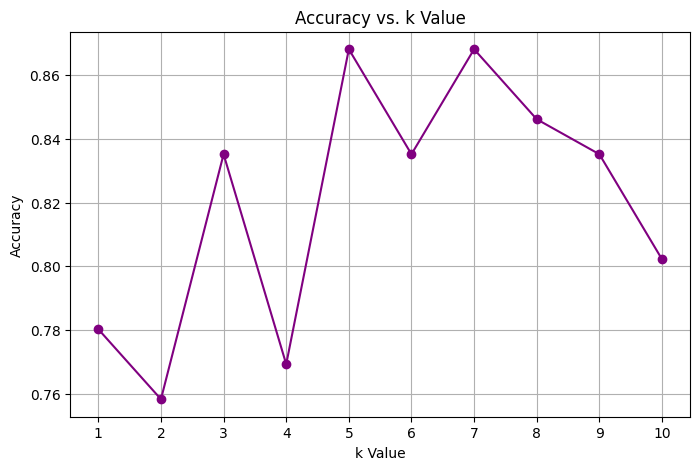

In [ ]:
k_values = list(range(1, 11))
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

# Plot the accuracies
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o', color='purple')
plt.title('Accuracy vs. k Value')
plt.xlabel('k Value')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid()
plt.show()

## Conclusion

The k-Nearest Neighbors (kNN) algorithm is a versatile tool for understanding datasets by leveraging the idea of similarity between data points. By analyzing the features of nearby points in a multidimensional space, kNN can classify new observations or predict outcomes based on existing patterns in the data. This intuitive approach makes it particularly useful for identifying clusters, detecting anomalies, and uncovering relationships between variables. Additionally, kNN's reliance on distance metrics highlights the importance of proper preprocessing, such as scaling and encoding, to ensure meaningful comparisons.

💡 **Main idea**: kNN classifies new points based on the features of k-nearest points. kNNs work best on balanced, low-dimensionality data sets.